In [21]:
import tensorflow as tf
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from Energy_Models.Transformer import Transformer
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
df = pd.read_csv('C:\\Users\\M4\\Desktop\\household_power_consumption.csv',parse_dates=['datetime'], index_col= 'datetime')

In [8]:
# resample the data on daily basis
df = df.resample('D').mean()
df.shape

(1442, 8)

In [9]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.000000,1.378788,12.439394,37.073064
2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583,25.657407
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722,13.214190
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472,9.119375
2006-12-20,1.545658,0.111804,242.308062,6.467361,0.000000,1.838889,9.765972,14.156111


In [10]:
def train_test_split(df):
    
    # compute split point
    end_idx = df.shape[0]* 70 // 100
    
    train_data = df.iloc[:end_idx, : ]
    test_data = df.iloc[end_idx:, :]
    
    return train_data, test_data

In [11]:
# Split the data into train and test
X_train, X_test = train_test_split(df)

In [12]:
from sklearn.preprocessing import MinMaxScaler
def scale_data(train, test):
    scaler = MinMaxScaler().fit(train)
    return scaler.transform(train), scaler.transform(test), scaler

In [13]:
# Scale the data
X_train, X_test, scaler = scale_data(X_train, X_test)

In [14]:
def convert_to_supervised(df):

    input_features = []
    ouput_feature = []
    
    len_df = df.shape[0]
    
    for i in range(len_df):
        
        end_idx = i + 7
        
        if end_idx > len_df-7:
            break
            
        input_x , output_y = df[i:end_idx, 1:], df[end_idx: end_idx+7, 0]
        
        input_features.append(input_x)
        ouput_feature.append(output_y)
    
    return np.array(input_features), np.array(ouput_feature)

In [15]:
# Split the training data into input features and out feature
X_train, Y_train = convert_to_supervised(X_train)
print('Shape of (training data) input features : %s and ouput feature %s' % (X_train.shape, Y_train.shape))

Shape of (training data) input features : (996, 7, 7) and ouput feature (996, 7)


In [185]:
#Y_train = Y_train.reshape((Y_train.shape[0],1))

In [16]:
X_train.shape,Y_train.shape

((996, 7, 7), (996, 7))

In [17]:
X_test, Y_test = convert_to_supervised(X_test)
print('Shape of (testing data) input features : %s and ouput feature %s' % (X_test.shape, Y_test.shape))

Shape of (testing data) input features : (420, 7, 7) and ouput feature (420, 7)


In [22]:
input_shape = X_train.shape[1:]
n_classes =7
model = Transformer(    
    input_shape,
    n_outputs=7,
    head_size=4,
    num_heads=4,
    ff_dim=32,
    num_transformer_blocks=10,
    mlp_units=[512],
    mlp_dropout=0.4,
    dropout=0.2,).build_model()

model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(),
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10)]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 7, 7)]       0           []                               
                                                                                                  
 layer_normalization_20 (LayerN  (None, 7, 7)        14          ['input_2[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_10 (Multi  (None, 7, 7)        503         ['layer_normalization_20[0][0]', 
 HeadAttention)                                                   'layer_normalization_20[0][0]'] 
                                                                                            

 ambda)                                                           'tf.__operators__.add_25[0][0]']
                                                                                                  
 layer_normalization_27 (LayerN  (None, 7, 7)        14          ['tf.__operators__.add_26[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv1d_26 (Conv1D)             (None, 7, 32)        256         ['layer_normalization_27[0][0]'] 
                                                                                                  
 dropout_28 (Dropout)           (None, 7, 32)        0           ['conv1d_26[0][0]']              
                                                                                                  
 conv1d_27 (Conv1D)             (None, 7, 7)         231         ['dropout_28[0][0]']             
          

 layer_normalization_34 (LayerN  (None, 7, 7)        14          ['tf.__operators__.add_33[0][0]']
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_17 (Multi  (None, 7, 7)        503         ['layer_normalization_34[0][0]', 
 HeadAttention)                                                   'layer_normalization_34[0][0]'] 
                                                                                                  
 dropout_35 (Dropout)           (None, 7, 7)         0           ['multi_head_attention_17[0][0]']
                                                                                                  
 tf.__operators__.add_34 (TFOpL  (None, 7, 7)        0           ['dropout_35[0][0]',             
 ambda)                                                           'tf.__operators__.add_33[0][0]']
          

In [73]:
history=model.fit(
    X_train,
    Y_train,
    validation_split=0.3,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
)

Epoch 1/100
22/22 [==============================] - 7s 76ms/step - loss: 0.0557 - val_loss: 0.0290
Epoch 2/100
22/22 [==============================] - 1s 29ms/step - loss: 0.0291 - val_loss: 0.0142
Epoch 3/100
22/22 [==============================] - 1s 30ms/step - loss: 0.0251 - val_loss: 0.0144
Epoch 4/100
22/22 [==============================] - 1s 30ms/step - loss: 0.0216 - val_loss: 0.0134
Epoch 5/100
22/22 [==============================] - 1s 30ms/step - loss: 0.0206 - val_loss: 0.0114
Epoch 6/100
22/22 [==============================] - 1s 31ms/step - loss: 0.0199 - val_loss: 0.0121
Epoch 7/100
22/22 [==============================] - 1s 33ms/step - loss: 0.0189 - val_loss: 0.0127
Epoch 8/100
22/22 [==============================] - 1s 31ms/step - loss: 0.0199 - val_loss: 0.0108
Epoch 9/100
22/22 [==============================] - 1s 31ms/step - loss: 0.0186 - val_loss: 0.0119
Epoch 10/100
22/22 [==============================] - 1s 31ms/step - loss: 0.0186 - val_loss: 0.0139

In [74]:
model.evaluate(X_train, Y_train, verbose=1)

32/32 [==============================] - 0s 9ms/step - loss: 0.0130


0.013028026558458805

In [75]:
model.evaluate(X_test, Y_test, verbose=1)

14/14 [==============================] - 0s 9ms/step - loss: 0.0097


0.009698278270661831

In [76]:
def print_metrics(model,Y_train,Y_pred_train,Y_test,Y_pred_test):
    print('Train MAE  value   : %.3f ' % mean_absolute_error(Y_train, Y_pred_train))
    print('Train MSE  value   : %.3f ' % mean_squared_error(Y_train, Y_pred_train))
    print('Train RMSE value   : %.3f ' % root_mean_squared_error(Y_train, Y_pred_train))
    print('Train R2   value   : %.3f ' % r2_score(Y_train, Y_pred_train))
    print('---------------------------------------------')
    print('Test  MAE  value   : %.3f ' % mean_absolute_error(Y_test, Y_pred_test))
    print('Test  MSE  value   : %.3f ' % mean_squared_error(Y_test, Y_pred_test))
    print('Test  RMSE value   : %.3f ' % root_mean_squared_error(Y_test, Y_pred_test))
    print('Test  R2   value   : %.3f ' % r2_score(Y_test, Y_pred_test))

In [77]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error, mean_absolute_percentage_error
def root_mean_squared_error(y_true, y_pred):    
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [78]:
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test) 

print("-" * 50)

print_metrics(model , Y_train , y_pred_train , Y_test , y_pred_test)

14/14 [==============================] - 0s 8ms/step
--------------------------------------------------
Train MAE  value   : 0.086 
Train MSE  value   : 0.013 
Train RMSE value   : 0.114 
Train R2   value   : 0.333 
---------------------------------------------
Test  MAE  value   : 0.076 
Test  MSE  value   : 0.010 
Test  RMSE value   : 0.098 
Test  R2   value   : 0.136 


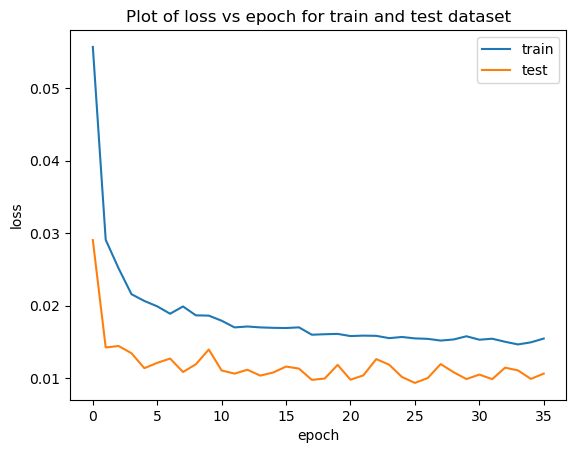

In [79]:
import matplotlib.pyplot as plt 
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()